# Limpieza Datos y EDA

In [1]:
import pandas as pd
import re
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ast
import unicodedata

In [2]:
df=pd.read_csv("anuncios_completo.csv")

* Funcion para desglosar columna "tags"

In [3]:
def limpiar_tags(df):
    def parse_list(val):
        if isinstance(val, list):
            return val
        try:
            return ast.literal_eval(val)
        except:
            return []

    df = df.copy()
    df['tags'] = df['tags'].apply(parse_list)

    def extraer_año(tags):
        for t in tags:
            if isinstance(t, str) and re.match(r'^\d{4}$', t):
                return int(t)
        return np.nan

    def extraer_combustible(tags):
        combustibles = {'Gasolina', 'Diésel', 'Eléctrico', 'Híbrido', 'Híbrido Enchufable', 'Gas'}
        for t in tags:
            if t in combustibles:
                return t
        return np.nan

    def extraer_kilometraje(tags):
        for t in tags:
            if isinstance(t, str):
                m = re.match(r'^([\d\.]+) km$', t.lower())
                if m:
                    return float(m.group(1).replace('.', ''))
        return np.nan

    def extraer_ubicacion(tags):
        if tags:
            return tags[-1]
        return np.nan

    def contiene_demo(tags):
        return any("demo" in str(t).lower() for t in tags)

    def contiene_km0(tags):
        return any(re.search(r'km[\s_]?0$', str(t).lower()) for t in tags)

    df['es_demo'] = df['tags'].apply(lambda x: 1 if contiene_demo(x) else 0)
    df['es_km0'] = df['tags'].apply(lambda x: 1 if contiene_km0(x) else 0)

    df['año'] = df['tags'].apply(extraer_año)
    df['combustible'] = df['tags'].apply(extraer_combustible)
    df['kilometraje'] = df['tags'].apply(extraer_kilometraje)
    df['ubicacion'] = df['tags'].apply(extraer_ubicacion)

    df.drop(columns=['tags'], inplace=True)

    return df

df = limpiar_tags(df)


* Funcion para desglosar columna "precios"

In [4]:
def limpiar_numero(texto):
    if isinstance(texto, str):
        match = re.search(r'[\d\.]+', texto)
        if match:
            num_str = match.group(0).replace('.', '')
            return int(num_str)
    return np.nan

def procesar_precios(df):
    df = df.copy()
    
    df['precios'] = df['precios'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    def extraer_precio_texto(precios_lista, clave):
        if isinstance(precios_lista, list):
            for item in precios_lista:
                if clave in item:
                    return item
        return np.nan
    
    df['precio_contado'] = df['precios'].apply(lambda x: extraer_precio_texto(x, "Precio al contado:"))
    df['precio_financiado'] = df['precios'].apply(lambda x: extraer_precio_texto(x, "Precio financiado:"))
    df['precio_nuevo'] = df['precios'].apply(lambda x: extraer_precio_texto(x, "Precio de venta nuevo*"))
    
    df['precio_contado'] = df['precio_contado'].apply(limpiar_numero)
    df['precio_financiado'] = df['precio_financiado'].apply(limpiar_numero)
    df['precio_nuevo'] = df['precio_nuevo'].apply(limpiar_numero)
    
    df.drop(columns=['precios'], inplace=True)
    
    return df

df = procesar_precios(df)

* Esta funcion localizamos cuando en la URL aparece la palabra "desde" y modificamos el "precio_contado" por el "precio_financiado" ya que en la pagina web vemos que los anuncios que contienen ese patron nos muestran en el "precio_contado" el precio a pagar mensualmente y en "precio_financiado" aparece el precio total y asi no tenemos errores en "precio_contado"

In [5]:
def precio_limpieza(df):
    def corregir_precio_contado(row):
        if "desde" in str(row["id_extraccion"]):
            return row["precio_financiado"]
        return row["precio_contado"]

    df["precio_contado"] = df.apply(corregir_precio_contado, axis=1)


    return df

df = precio_limpieza(df)

* Creamos una columna binaria para saber si el coche tiene financiacion o no

In [6]:
df['financiacion_disponible'] = df['precio_financiado'].notnull().astype(int)


* Eliminamos la columna original despues de pasar los datos a la columna binaria ya que hemos decidido que solo queremos saber si el coche puede ser financiado o no

In [7]:
df.drop(columns=['precio_financiado'], inplace=True)

* Eliminamos todos los NaNs de la columna target "precio_contado" ya que muchos de esos NaNs son coches que ya se han vendido y como nuestra columna target es "precio_contado" necesitamos que no tenga NaNs

In [8]:
df = df.dropna(subset=['precio_contado']).reset_index(drop=True)

* Quitamos tildes a las ubicaciones para no tener errores con el mapping de longitud y latitud 

In [9]:
def quitar_tildes(texto):
    if isinstance(texto, str):
        return ''.join(
            c for c in unicodedata.normalize('NFD', texto)
            if unicodedata.category(c) != 'Mn'
        )
    return texto

df['ubicacion'] = df['ubicacion'].apply(quitar_tildes)


* Creamos las columnas "latitud" y "longitud" para cada Ubicacion

In [10]:
coordenadas_ubicaciones = {
    'Madrid': (40.4168, -3.7038),
    'Barcelona': (41.3851, 2.1734),
    'Malaga': (36.7213, -4.4214),
    'Islas Baleares': (39.5696, 2.6502),  
    'Alicante': (38.3452, -0.4810),
    'Vizcaya': (43.2630, -2.93499),
    'Castellon': (39.9864, -0.0513),
    'Avila': (40.6560, -4.7003),
    'Asturias': (43.3619, -5.8494),
    'Badajoz': (38.8794, -6.9707),
    'Valencia': (39.4699, -0.3763),
    'Tenerife': (28.2916, -16.6291),
    'Cordoba': (37.8882, -4.7794),
    'Alava': (42.8513, -2.6721),
    'Tarragona': (41.1189, 1.2445),
    'Girona': (41.9794, 2.8214),
    'Caceres': (39.4702, -6.3723),
    'Las Palmas': (28.1235, -15.4363),
    'Toledo': (39.8628, -4.0273),
    'Zaragoza': (41.6488, -0.8891),
    'Orense': (42.3400, -7.8633),
    'Cadiz': (36.5271, -6.2886),
    'Segovia': (40.9486, -4.1186),
    'Guipuzcoa': (43.3130, -1.9746),
    'Leon': (42.5987, -5.5671),
    'Cantabria': (43.1828, -3.9871),
    'Lleida': (41.6176, 0.6200),
    'Ciudad Real': (38.9860, -3.9279),
    'Pontevedra': (42.4333, -8.6333),
    'Salamanca': (40.9701, -5.6635),
    'Valladolid': (41.6523, -4.7245),
    'Palencia': (42.0090, -4.5271),
    'Almeria': (36.8340, -2.4637),
    'Huelva': (37.2614, -6.9447),
    'Sevilla': (37.3891, -5.9845),
    'Lugo': (43.0125, -7.5559),
    'Granada': (37.1773, -3.5986),
    'Huesca': (42.1401, -0.4089),
    'Murcia': (37.9922, -1.1307),
    'La Coruna': (43.3623, -8.4115),
    'Burgos': (42.3439, -3.6969),
    'Albacete': (38.9943, -1.8564),
    'La Rioja': (42.4627, -2.4450),
    'Cuenca': (40.0704, -2.1374),
    'Jaen': (37.7796, -3.7849),
    'Navarra': (42.6951, -1.6761),
    'Zamora': (41.5031, -5.7455),
    'Guadalajara': (40.6333, -3.1667),
    'Soria': (41.7636, -2.4679),
    'Teruel': (40.3440, -1.1069),
    'Melilla': (35.2912, -2.9381),
    'Ceuta': (35.8894, -5.3213)
}


df['latitud'] = df['ubicacion'].map(lambda x: coordenadas_ubicaciones.get(x, (None, None))[0])
df['longitud'] = df['ubicacion'].map(lambda x: coordenadas_ubicaciones.get(x, (None, None))[1])

*Desglosamos columna "detalles_ficha"

In [11]:
def asegurar_lista(valor):
    if isinstance(valor, list):
        return valor
    elif isinstance(valor, str):
        try:
            lista = ast.literal_eval(valor)
            if isinstance(lista, list):
                return lista
            else:
                return []
        except:
            return []
    else:
        return []

def extraer_garantia_num(detalles):
    detalles = asegurar_lista(detalles)
    for detalle in detalles:
        if "Garantía:" in detalle:
            no_match = re.search(r'Garantía:\s*No', detalle, re.IGNORECASE)
            si_match = re.search(r'Garantía:\s*Sí', detalle, re.IGNORECASE)
            meses_match = re.search(r'Garantía:\s*(\d+)\s*meses?', detalle, re.IGNORECASE)
            if no_match:
                return pd.NA
            elif si_match:
                return 0
            elif meses_match:
                return int(meses_match.group(1))
    return pd.NA

def normalizar_texto(texto):
    return ''.join(
        c for c in unicodedata.normalize('NFKD', texto)
        if not unicodedata.combining(c)
    ).lower().strip()

def extraer_transmision(detalles):
    detalles = asegurar_lista(detalles)
    for detalle in detalles:
        detalle_norm = normalizar_texto(detalle)
        if detalle_norm == "automatico":
            return "Automático"
        elif detalle_norm == "manual":
            return "Manual"
    return None

def extraer_matriculacion(detalles):
    detalles = asegurar_lista(detalles)
    for item in detalles:
        m = re.search(r'Matriculado: (\d{2}/\d{4})', item)
        if m:
            return m.group(1)
    return np.nan

def extraer_potencia(detalles):
    detalles = asegurar_lista(detalles)
    for item in detalles:
        m = re.search(r'(\d+)\s?cv', item, re.IGNORECASE)
        if m:
            return int(m.group(1))
    return np.nan

def extraer_puertas(detalles):
    detalles = asegurar_lista(detalles)
    for item in detalles:
        m = re.search(r'(\d+)\sPuertas', item)
        if m:
            return int(m.group(1))
    return np.nan

def extraer_asientos(detalles):
    detalles = asegurar_lista(detalles)
    for item in detalles:
        m = re.search(r'(\d+)\s?asientos', item, re.IGNORECASE)
        if m:
            return int(m.group(1))
    return np.nan

def extraer_tipo_carroceria(detalles):
    detalles = asegurar_lista(detalles)
    tipo_carroceria = None

    for item in detalles:
        if item in ['Descapotable o convertible', 'Descapotable']:
            tipo_carroceria = 'Descapotable'
        elif item in ['Berlina mediana o grande', 'Berlina']:
            tipo_carroceria = 'Berlina'
        elif item in ['Deportivo o coupé', 'Deportivo', 'Coupé']:
            tipo_carroceria = 'Deportivo'
        elif item in ['Todo Terreno', 'Stationwagon', 'Monovolumen', 'SUV', 'Familiar', 'Pickup', '4x4', 
                      '4x4, SUV o pickup', 'Pequeño', 'Sedán', 'Hatchback', 'Convertible']:
            tipo_carroceria = item
        elif item == 'Pequeño':
            tipo_carroceria = 'Pequeño'
        elif item == 'Convertible':
            tipo_carroceria = 'Convertible'

    return tipo_carroceria


def extraer_mes_matriculacion(detalles):
    detalles = asegurar_lista(detalles)
    for detalle in detalles:
        match = re.search(r'Matriculado:\s*(\d{2})/\d{4}', detalle)
        if match:
            return int(match.group(1))
    return None

def procesar_detalles_ficha(df):
    df = df.copy()

    df['garantia'] = df['detalles_ficha'].apply(extraer_garantia_num).astype('Int64')
    df['transmision'] = df['detalles_ficha'].apply(extraer_transmision)
    df['matriculacion'] = df['detalles_ficha'].apply(extraer_matriculacion)
    df['potencia_cv'] = df['detalles_ficha'].apply(extraer_potencia)
    df['puertas'] = df['detalles_ficha'].apply(extraer_puertas)
    df['asientos'] = df['detalles_ficha'].apply(extraer_asientos)
    df['tipo_carroceria'] = df['detalles_ficha'].apply(extraer_tipo_carroceria)
    df['mes'] = df['detalles_ficha'].apply(extraer_mes_matriculacion)
    df.drop(columns=['detalles_ficha'], inplace=True)

    return df

df = procesar_detalles_ficha(df)


* En esta funcion tenemos extras de limpieza como por ejemplo : Cambiamos tipo de dato de las columnas "año", "mes" y "timestamp_extraccion" , a la columna "titulo" le quitamos la marca del coche y renombramos columna como "modelo", eliminamos columnas que ya no necesitamos, eliminamos una garantia que teniamos incorrecta y por ultimo en la columna "combustible" algunos datos se capturaron como "Gas" en vez de "Gasolina" simplemente cambiamos todos esos datos a su nombre correcto

In [12]:
def extra(df):
    df['año'] = df['año'].astype('Int64')
    df['mes'] = df['mes'].astype('Int64')
    df['timestamp_extraccion'] = pd.to_datetime(df['timestamp_extraccion'], errors='coerce')
    df['modelo'] = df.apply(lambda row: row['titulo'].replace(row['marca'], '').strip(), axis=1)
    df.drop(columns=['url'], inplace=True)
    df.drop(columns=["titulo"], inplace=True)
    df.drop(columns=['matriculacion'], inplace=True)
    df.drop(columns=['precio_nuevo'], inplace=True)
    df = df[df['garantia'] != 3660].reset_index(drop=True)
    df.loc[df['combustible'].str.contains('gas', case=False, na=False), 'combustible'] = 'Gasolina'

    
    return df

df = extra(df)



* Renombramos columna "año" y "mes" para que coincida con la base de datos

In [13]:
df.rename(columns={
    'año': 'año_matriculacion',
    'mes': 'mes_matriculacion'
}, inplace=True)


* Guardamos los datos despues de la limpieza en un .csv para seguir trabajando con ellos

In [14]:
df.to_csv('datos_limpios.csv', index=False)

* Aqui ya empezamos la parte de EDA, empezamos viendo la correlacion entre todas las columnas numericas

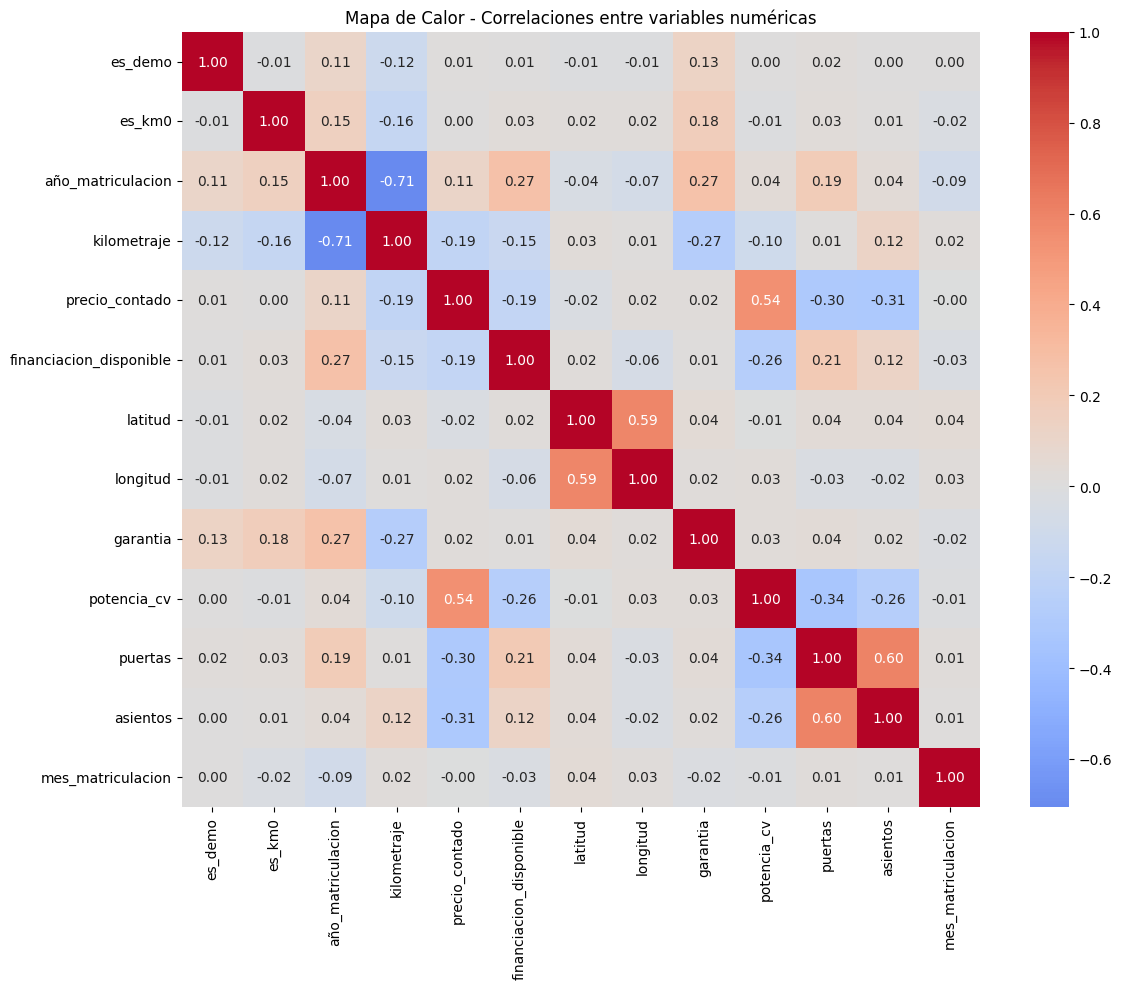

In [15]:
numeric_cols = df.select_dtypes(include=np.number)

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Mapa de Calor - Correlaciones entre variables numéricas')
plt.tight_layout()
plt.show()

* Aqui tenemos un grafico con la distribucion del precio y un grafico que nos muestra las 10 marcas con mas coches

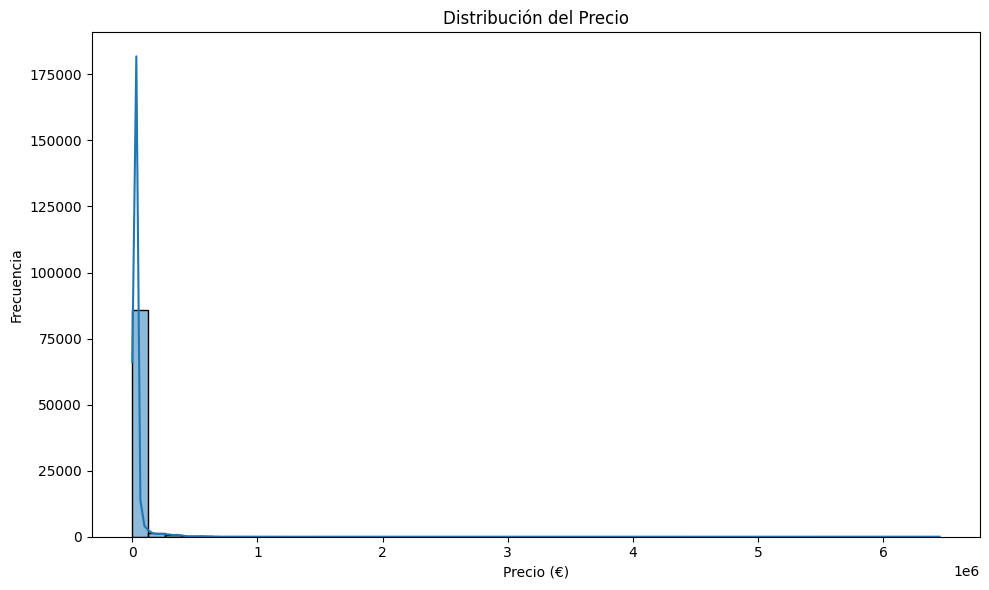

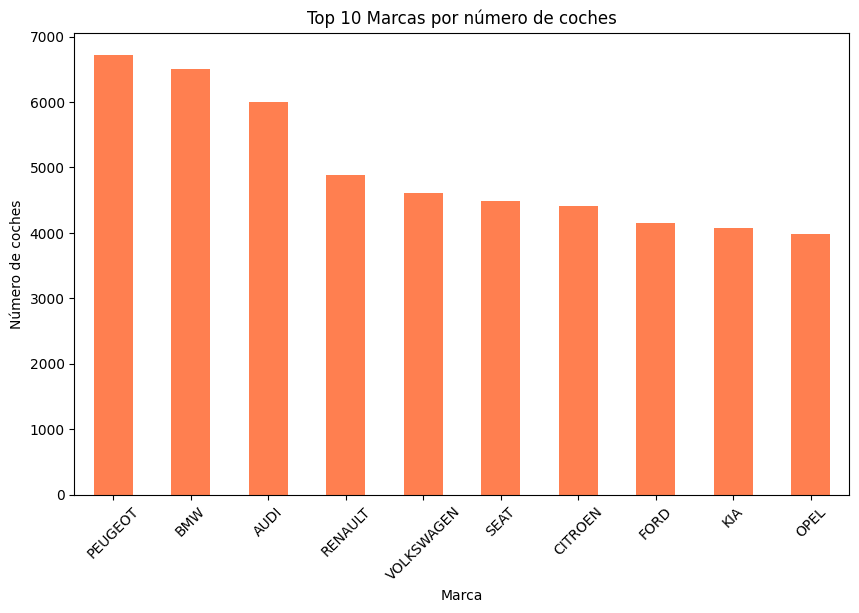

In [16]:
plt.figure(figsize=(10,6))
sns.histplot(df['precio_contado'], bins=50, kde=True)
plt.title('Distribución del Precio')
plt.xlabel('Precio (€)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


top_marcas = df['marca'].value_counts().nlargest(10)
plt.figure(figsize=(10,6))
top_marcas.plot(kind='bar', color='coral')
plt.title('Top 10 Marcas por número de coches')
plt.xlabel('Marca')
plt.ylabel('Número de coches')
plt.xticks(rotation=45)
plt.show()

* Aqui tenemos un grafico de barras con los precios de todos los coches y la cantidad de coches que hay en cada rango de precios que hemos creado 

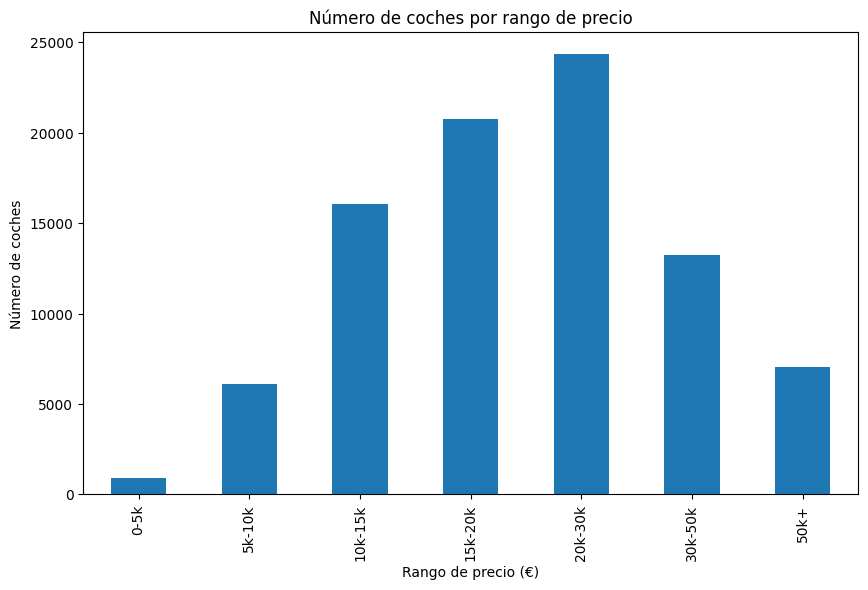

In [17]:
bins = [0, 5000, 10000, 15000, 20000, 30000, 50000, df['precio_contado'].max()]
labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-30k', '30k-50k', '50k+']

df['precio_rango'] = pd.cut(df['precio_contado'], bins=bins, labels=labels, include_lowest=True)


frecuencias = df['precio_rango'].value_counts().sort_index()

plt.figure(figsize=(10,6))
frecuencias.plot(kind='bar')
plt.title('Número de coches por rango de precio')
plt.xlabel('Rango de precio (€)')
plt.ylabel('Número de coches')
plt.show()


* Aqui podemos ver la distribucion del precio de las 10 ubicaciones con mas coches en un boxplot

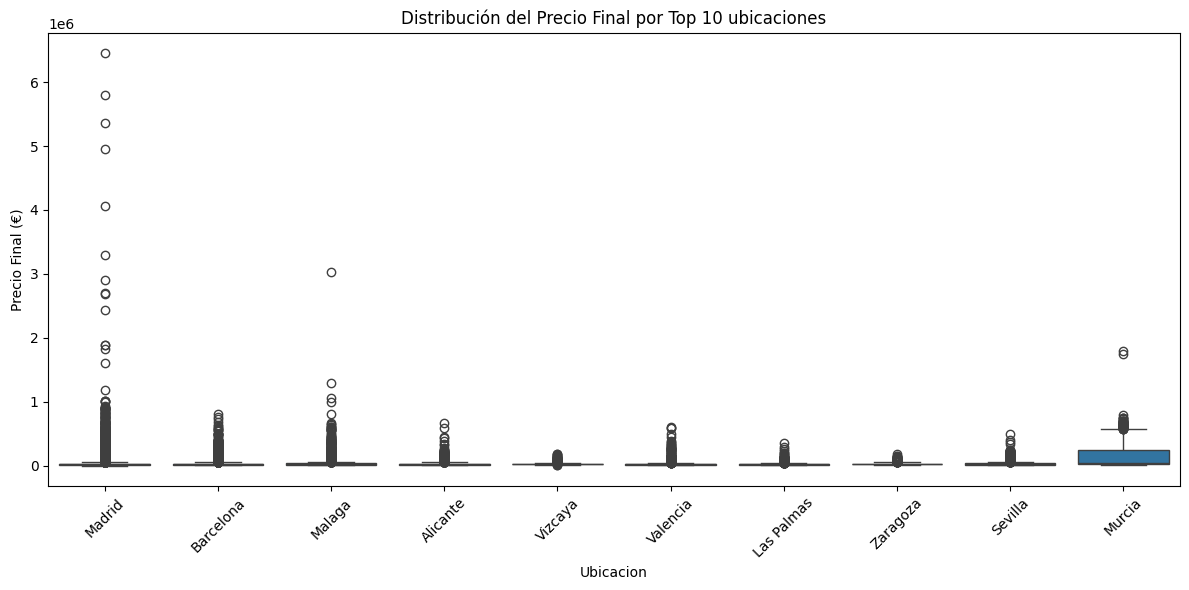

In [18]:
top_ubicacion = df['ubicacion'].value_counts().nlargest(10).index
df_top = df[df['ubicacion'].isin(top_ubicacion)]

plt.figure(figsize=(12,6))
sns.boxplot(data=df_top, x='ubicacion', y='precio_contado')
plt.title('Distribución del Precio Final por Top 10 ubicaciones')
plt.xlabel('Ubicacion')
plt.ylabel('Precio Final (€)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



* Graficamos un scatter de relacion entre precio y antigüedad del coche 

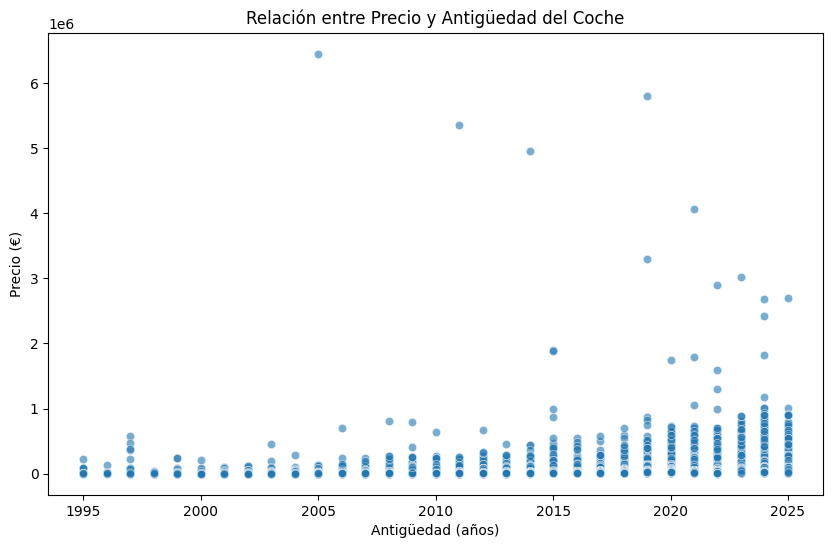

In [19]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='año_matriculacion', y='precio_contado', alpha=0.6)
plt.title('Relación entre Precio y Antigüedad del Coche')
plt.xlabel('Antigüedad (años)')
plt.ylabel('Precio (€)')
plt.show()


* Aplicamos la transformación logarítmica a la columna "precio_contado" para mejorar su distribución y manejar mejor la escala de los precios.


In [20]:
df['log_precio'] = np.log1p(df['precio_contado'])


* Graficamos distribucion del precio de la columna que le hemos aplicado logaritmo al precio

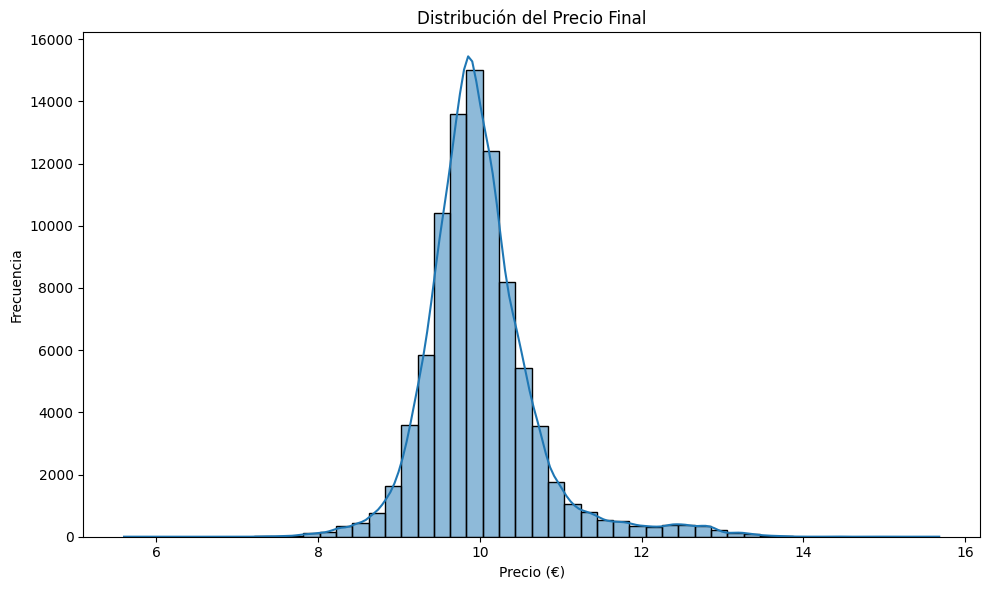

In [21]:
plt.figure(figsize=(10,6))
sns.histplot(df['log_precio'], bins=50, kde=True)
plt.title('Distribución del Precio Final')
plt.xlabel('Precio (€)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

* Creamos un boxplot usando Plotly Express para visualizar la distribucion del "precio_contado" en las 10 ubicaciones con mas anuncios

In [22]:
fig = px.box(df_top, x='ubicacion', y='precio_contado', title='Precio segun las top 10 ubicaciones')
fig.show()
